# Test

As this is my first usage of CRPropa besides running the examples, I will just mimic those. I will try to create a particle source and let them spread evenly in any direction.

In [1]:
from crpropa import *

Most simple setup is just a simple propagation module and stop after some fixed trajectory length. I don't care about units now but just use the usual ones in the reign of CRPropa.

In [2]:
sim = ModuleList()
sim.add(SimplePropagation(0.1*Mpc, 0.1*Mpc))
sim.add(MaximumTrajectoryLength(10*Mpc))

To view the result in a trajectory plot, the data of each step must be stored.

In [3]:
output = ParticleCollector(10000, True) 
sim.add(output)

Now we need a source, located in the origin, emitting just any kind of particles in any direction.

Usually here an energy range is specified, but that is not needed. CRPropa doesn't care about time and speed, energy is for interactions,m which we don't have here. The amount of distance moved in each step is just the stepsize given as arguments to the SimplePropagation module.

In [4]:
source = Source()
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourceIsotropicEmission())
source.add(SourcePosition(Vector3d(0, 0, 0)*Mpc))

All is setup to run, the amount of particles created by source is an argument to run. False indicates, that we don't need to simulate child-particles, as there will not be any.

In [5]:
sim.run(source, 30, False)

To plot the trajectories with matplotlib the code from trajectories example (simplified and centered) will do.

<IPython.core.display.Javascript object>


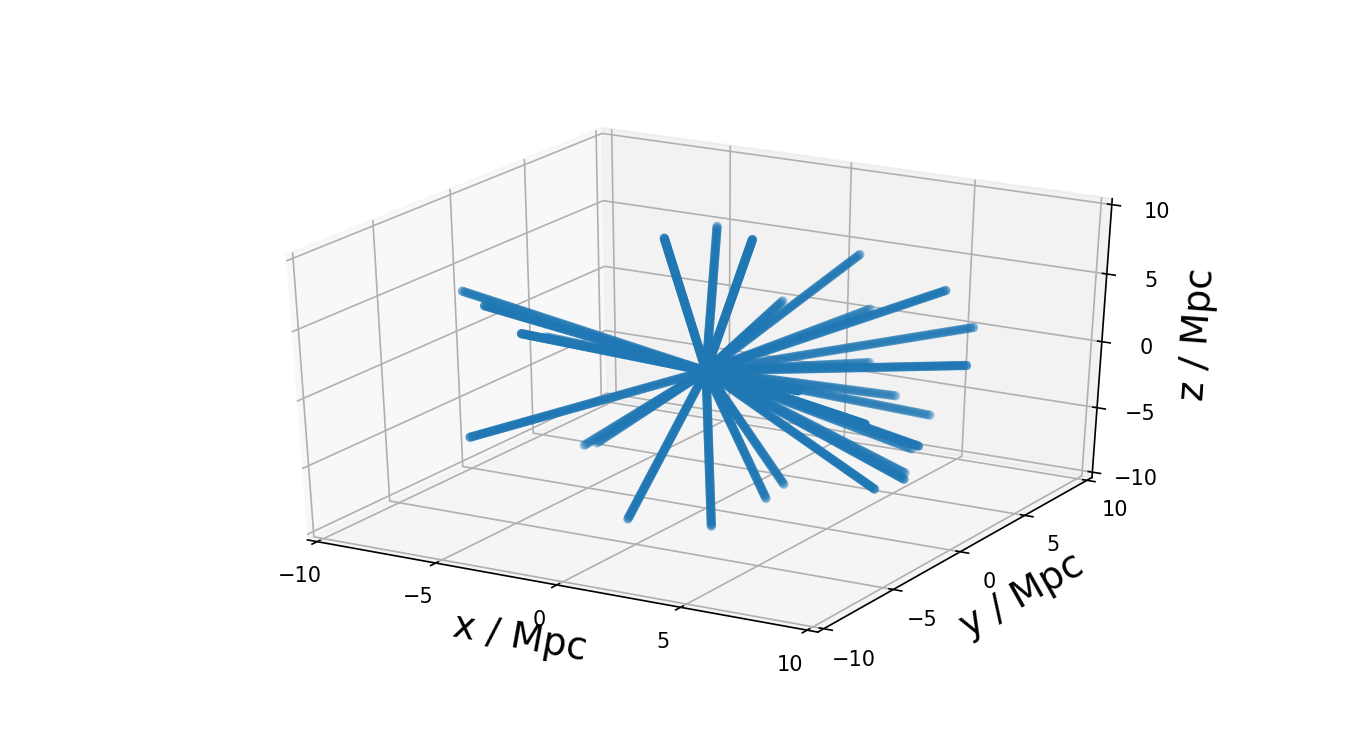

In [6]:
%matplotlib notebook
from pylab import *
from mpl_toolkits.mplot3d import axes3d

data = []
for c in output:
    pos = c.current.getPosition()
    data.append([c.getTrajectoryLength(), pos.getX(), pos.getY(), pos.getZ()])
data = np.array(data) / Mpc

# trajectory points
x, y, z = data[:,1], data[:,2], data[:,3]

fig = plt.figure(figsize=(9, 5))#plt.figaspect(0.5))
ax = fig.gca(projection='3d')# , aspect='equal'

ax.scatter(x,y,z, 'o', lw=0)

ax.set_xlabel('x / Mpc', fontsize=18)
ax.set_ylabel('y / Mpc', fontsize=18)
ax.set_zlabel('z / Mpc', fontsize=18)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_zlim((-10, 10))
ax.xaxis.set_ticks((-10, -5, 0, 5, 10))
ax.yaxis.set_ticks((-10, -5, 0, 5, 10))
ax.zaxis.set_ticks((-10, -5, 0, 5, 10))

show()

Now we do the same analysis we will do with diffusion model.

In [7]:
from collections import defaultdict
import numpy as np
grouped = defaultdict(list)
d = []
r_sq = []
d_end = 0
#print(data.dtype.names)
for di, X, Y, Z in data:
    grouped[di].append(X**2 + Y**2 + Z**2)
for di in grouped: 
    d.append(di)
    r_sq.append(np.mean(grouped[di]))
    d_end = max(d_end, di)
print('After last step:')
print('r_min   = ' + str(sqrt(np.min(grouped[d_end]))))
print('r_max   = ' + str(sqrt(np.max(grouped[d_end]))))
r_avg = np.mean(sqrt(grouped[d_end]))
print('< r >   = ' + str(r_avg))
print('< r >²  = ' + str(r_avg**2))
r_sq_avg = np.mean(grouped[d_end])
print('< r² >  = ' + str(r_sq_avg))
# in this simple example <r²> is so close to <r>² that numerically <r²> < <r>² is possible
# math excludes this, and we fix by taking abs()
print('sigma_r = ' + str(sqrt(abs(r_sq_avg - r_avg**2))))

After last step:
r_min   = 10.0
r_max   = 10.0
< r >   = 10.0
< r >²  = 100.0
< r² >  = 100.0
sigma_r = 2.06476546236e-07


In [8]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*(x**b)

popt, pcov = curve_fit(func, d, r_sq, bounds=(0, [4.0, 2.0]))
D = popt[0]
alpha = popt[1]
print('D = ' + str(D))
print('alpha = ' + str(D))
print()
print('r_sq = ' + str(D) + ' * d ^ ' + str(alpha))

D = 1.00000009727
alpha = 1.00000009727

r_sq = 1.00000009727 * d ^ 1.99999995385


D is the "diffusion constant" that results from no diffusion at all. And of course the graph in that case is a parabola.

<IPython.core.display.Javascript object>


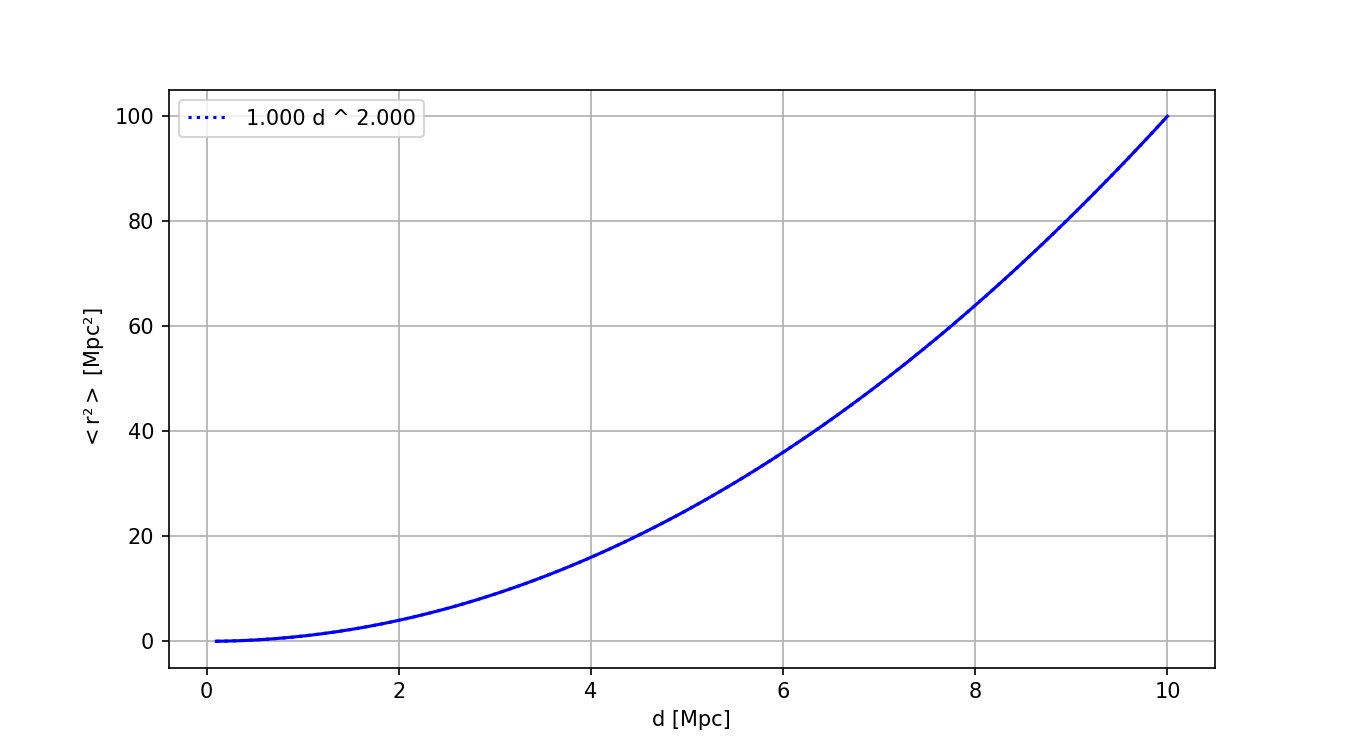

In [9]:
figure(figsize=(9, 5))
plot(d, r_sq, 'b-')
plot(d, func(d, D, alpha), 'b:', label='%.3f d ^ %.3f' % tuple(popt))
grid()
ylabel('$<$r²$>$ [Mpc²]')
xlabel('d [Mpc]')
legend()
show()